In [1]:
!pip install python-Levenshtein

     -------------------------------------- 100.6/100.6 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 2.8 MB/s eta 0:00:00


In [157]:
import torch
import re
import pandas as pd
import pickle
import numpy as np
from gensim.models.phrases import Phraser
from torch.utils.data import TensorDataset, DataLoader

In [158]:
#process materials:
ev_path = "processors/Englishwords.xlsx"
sf_path =  "processors/Shortform.xlsx"
stopwords_vn_path = "processors/stopwords_vn_dash.txt"
englishwords = pd.read_excel(ev_path, index_col= "English")
shortform = pd.read_excel(sf_path, index_col= "Short")

#phraser for word2vec
bigram = Phraser.load("saves/bigram.pkl")

#word2idx
word2idx = pickle.load(open("saves/word2idx.pickle", "rb"))

In [161]:
# print(englishwords)
z = pickle.load(open("saves/dictionary_foody.pickle", "rb"))
print(z)
# print('===')
# print(word2idx)

{'sâu_thẳm': 1, 'cao_ốc': 2, 'khẩu_khí': 3, 'chữ_ngũ': 4, 'bôi_nhọ': 5, 'học_sinh': 6, 'ngã_lòng': 7, 'chị': 8, 'đối_kháng': 9, 'ống_vôi': 10, 'nhẩy': 11, 'chập_tối': 12, 'địa': 13, 'tung_tích': 14, 'xưa': 15, 'miễn_thứ': 16, 'hầm_hầm': 17, 'nhờ_nhờ': 18, 'bán_kính': 19, 'dạ_quang': 20, 'lười_biếng': 21, 'nghe_lóm': 22, 'nhà_xí': 23, 'bốc_cháy': 24, 'sứ_đoàn': 25, 'nguyên_hình': 26, 'vôi_vữa': 27, 'dư_giả': 28, 'cảu_nhảu': 29, 'tầm_tã': 30, 'gồi': 31, 'phụ_phẩm': 32, 'nhiệt_năng': 33, 'dưới': 34, 'nhan_sắc': 35, 'sát_khuẩn': 36, 'nhập_cục': 37, 'vào': 38, 'hoa_xoè': 39, 'chiến': 40, 'nối_nghiệp': 41, 'nàng_thơ': 42, 'âu_là': 43, 'khảo_sát': 44, 'trăn': 45, 'phẩm_giá': 46, 'nhân_viên': 47, 'dặng_hắng': 48, 'chạy_tang': 49, 'đem_thân': 50, 'điên_loạn': 51, 'tổ_tiên': 52, 'thỉnh_cầu': 53, 'nghĩa_đệ': 54, 'trâng_tráo': 55, 'rốt': 56, 'kinh_vĩ': 57, 'nhà_chọc_trời': 58, 'lao': 59, 'nghị_gật': 60, 'âm_cực': 61, 'chứng_khoán': 62, 'đồng_bộ': 63, 'thất_tín': 64, 'hổng': 65, 'khoang': 66, 'ruỗn

In [131]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [132]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [133]:
def isNaN(string):
    return string != string
def preprocess(text):  
  try:
    text = re.sub('<[^>]*>', '', text)
    text = deEmojify(text)
  except:
    print("An exception occurred", text)
  

  #thay chữ cái viết hoa thành viết thường
  text = text.lower()

  #xóa dấu ngắt câu, xóa link và các chữ có chứa chữ số
  clean_text = []
  punc_list = r'.,;:?!\|/&@`~()-_@①②③④⑤⑥⑦⑧⑨#$%^*\'\"'
  for w in (text.split()):
    if "http" in w:
      continue
    clean_text.append(w)
  text = ' '.join(clean_text)
  for punc in punc_list:
    text = text.replace(punc, ' ')

  #xóa bỏ các chữ cái lặp liên tiếp nhau (đỉnhhhhhhhhhh, vipppppppppppppppp)
  length = len(text)
  char = 0
  while char <length-1:
    if text[char] == text[char+1]:
      text = text[:char]+text[char+1:]
      #print(text)
      length-=1
      continue
    char+=1  
  numbers = ["không", "một", "hai", "ba", "bốn", "năm", "sáu", "bảy", "tám", "chín"]
  #chuyển đổi các từ tiếng anh và viết tắt thông dụng sang tiếng Việt chuẩn:
  text_split = text.split()
  for i, w in enumerate(text_split):
    if w in englishwords.index:
      text_split[i] = str(englishwords.loc[w, "Vietnamese"])
    if w in shortform.index:
      text_split[i] = str(shortform.loc[w, "Long"])
    if w.isdigit():
      text_split[i] = ' '.join([numbers[int(c)] for c in w]) 
  text = ' '.join(text_split)

  #loại bỏ tất cả các kí tự đặc biệt còn lại
  digits_and_characters = 'aăâbcdđeêfghijklmnoôơpqrstuưvxywzáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệíìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ0123456789 '
  text = ''.join([i for i in text if i in digits_and_characters])
  return text


In [134]:
x = preprocess('aaa h ă âbcdđ h')
print(x)

a giờ ă âbcdđ giờ


In [135]:
#split all sentences in corpus
def splitCorpus(corpus):
  t = [sentence.split() for sentence in corpus]
  return t
#join all splited sentences to a big text document
def joinAllSplit(tokenized_sentences):
  sentences = [' '.join(sentence) for sentence in tokenized_sentences]
  return ' '.join(sentences)

#below function get performe preprocessing and remove unknown words
def prepros(sentences):
  new_sentences = [preprocess(sentence) for sentence in sentences]
  splitted_sentences = splitCorpus(new_sentences)
  new = []
  for sentence in bigram[splitted_sentences]:
    new_sentence = ' '.join([word for word in sentence if word in word2idx.keys()])
    new.append(new_sentence)
  return new

#convert words to numbers
def sentenceToInt(sentences):
  #print(sentences)
  int_sentences = []
  for sentence in sentences:
    int_sentence = [word2idx[word] for word in sentence.split()]   
    int_sentences.append(int_sentence)
  return int_sentences

#pad int_sentences to the feature_leng
def padFeature(sentences, feature_leng = 50):
  smatrix = np.zeros((len(sentences), feature_leng))
  for sen_index, sentence in enumerate(sentences):
    padding = max(0, feature_leng - len(sentence))
    for word_index in range(feature_leng):
      if word_index < padding:
        smatrix[sen_index, word_index] = 0
      else:
        smatrix[sen_index, word_index] = sentence[word_index-padding]
  return smatrix

def process(sentences, feature_leng = 50):
  int_sentences = sentenceToInt(sentences)
  feature_matrix = padFeature(int_sentences, feature_leng = 50)
  return feature_matrix


In [136]:
import torch.nn as nn

#model with 3 part: embedding layer -> stack lstms -> fc layers with softmax classifier
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, n_cell, emb_matrix, drop_prob = 0.2):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #embedding layer
        self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze = False)
        # LSTM layers
        self.lstm = nn.LSTM(input_size = embedding_dim,hidden_size = hidden_dim, num_layers = n_layers, batch_first = True, dropout = drop_prob)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers 
        self.fc = nn.Linear(hidden_dim, output_size)
        #self.fc1 = nn.Linear(hidden_dim, hidden_dim*2)
        #self.relu1 = nn.LeakyReLU()
        #self.fc2 = nn.Linear(hidden_dim*2, output_size)
      
        self.softmax = nn.Softmax(dim = 1)
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        #print(x)
        # embeddings and lstm_out

        embeds = self.embedding(x)
        embeds = embeds.float()
        #print(type(embeds))
        #print(embeds)
        lstm_out, hidden = self.lstm(embeds, hidden)
        #print(lstm_out.shape)
        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        #print(lstm_out.shape)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        #print(out.shape)
        #out = lstm_out[:, -1, :]
        #print(out.shape)
        out = self.fc(out)
        #out = self.fc1(out)
        #out = self.fc2(out)
        #print(out.shape)
        # sigmoid function
        #print(out.shape)
        out = out.contiguous().view(batch_size, -1, self.output_size)
        out = out[:, -1, :]
        out = self.softmax(out)
        # reshape to be batch_size first
        #print(out.shape)
        #out = out.view(batch_size,n_cell, -1)
        #print(out.shape)
        #out = out[:, -1] # get last batch of labels
        #print(out.shape)
        # return last sigmoid output and hidden state

        return out, hidden
    
    
    def init_hidden(self, batch_size, train_on_gpu = False):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float())
        
        return hidden

In [137]:
# Import Data
test = pd.read_csv("./input/test.csv")
train = pd.read_csv("./input/full_train.csv")

# drop columns 'RevId','UserId','image_urls', 'Unnamed: 0'
train.drop(columns=['RevId','UserId','image_urls', 'Unnamed: 0'], inplace=True)
test.drop(columns=['RevId','UserId','image_urls', 'Unnamed: 0'], inplace=True)
train.head()

,Comment,Rating
0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",1.0
1,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,0.0
2,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",1.0
3,Em có đọc review thấy mng bảo trà sữa nướng đề...,0.0
4,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",1.0


In [138]:
from sklearn.model_selection import train_test_split
# split data into train and validation 
# train_df, valid_df = train_test_split(train)
# print(train_df.shape)
# print(valid_df.shape)

In [139]:
# Drop rows with empty text
print(train.shape)
train = train[train.Comment == train.Comment]
train = train[train.Rating == train.Rating]
print(train.shape)

X,y = train['Comment'].values,train['Rating'].values
# X = prepros(X)
# print(X)
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

(9073, 2)
(9070, 2)


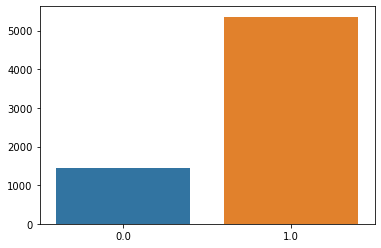

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array([1.0,0.0]),y=dd.values)
plt.show()

In [141]:
x_train = prepros(x_train)
x_train = process(x_train)
print(x_train)
print('====')
x_test = prepros(x_test)
x_test = process(x_test)
print(x_test)
print('====')
print(y_train)
print('====')
print(y_test)

[[    0.     0.     0. ... 10639.  3368.  9881.]
 [    0.     0.     0. ...  7067.  9844.  1983.]
 [ 9707.  7596.  3032. ...  6887.  6654.  4276.]
 ...
 [    0.     0.     0. ...  1417.  1373.  5944.]
 [    0.     0.     0. ...   467.  2549.  3828.]
 [ 7460.  8307.  9516. ...  1620. 11946. 11885.]]
====
[[ 6147.  7067.  4097. ...  6803.  5432.  3898.]
 [    0.     0.     0. ...  1542.  3958.  7596.]
 [    0.     0.     0. ... 10319.  2549.  6283.]
 ...
 [ 6223.  6321. 12098. ...  5285.  9776.  9516.]
 [ 8093.  6605.  7775. ... 11646. 11146.  1216.]
 [    0.     0.     0. ...  2954.  1789.  6742.]]
====
[1. 1. 1. ... 1. 1. 1.]
====
[0. 0. 1. ... 1. 1. 1.]


In [142]:
# create Tensor datasets


x_train = x_train.astype(np.int64)
x_train = np.array(x_train)
# x_train = np.array(x_train).tolist()

print(x_train)

y_train = y_train.astype(np.int64)
x_test = x_test.astype(np.int64)
y_test = y_test.astype(np.int64)
print(y_train, y_test)
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
print(train_data)

from torch.autograd import Variable
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# for i, (inputs, targets) in enumerate(train_loader):
#     with torch.no_grad():
#         inputs = Variable(inputs)
#         targets = Variable(targets)
#         print("targets.data", targets)
#         print("inputs.data", inputs)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

[[    0     0     0 ... 10639  3368  9881]
 [    0     0     0 ...  7067  9844  1983]
 [ 9707  7596  3032 ...  6887  6654  4276]
 ...
 [    0     0     0 ...  1417  1373  5944]
 [    0     0     0 ...   467  2549  3828]
 [ 7460  8307  9516 ...  1620 11946 11885]]
[1 1 1 ... 1 1 1] [0 0 1 ... 1 1 1]


In [143]:
# obtain one batch of training data
print(train_loader)
dataiter = iter(train_loader)
print(dataiter)
# sample_x, sample_y = dataiter.next()
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 50])
Sample input: 
 tensor([[ 7724,  8324,  9419,  ..., 11654,  1173,  5264],
        [    0,     0,     0,  ...,  2363,  6275, 10645],
        [ 3665,  9419,  7067,  ..., 12309,  7706, 10574],
        ...,
        [    0,     0,     0,  ...,  4667,  4394,   563],
        [ 2815,  6465, 12273,  ...,  1847,   669,  2383],
        [ 9068,  2564,  8304,  ...,  4486, 10832,  8636]])
Sample input: 
 tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0])


In [144]:
#word2idx
word2idx = pickle.load(open("saves/word2idx.pickle", "rb"))

# Load model
emb_matrix = torch.zeros((len(word2idx)+1,200))

model = SentimentLSTM(output_size= 3, embedding_dim=200, hidden_dim= 128, n_layers= 2, n_cell = 50, emb_matrix=emb_matrix, drop_prob = 0.2)

#moving to gpu
# model.to(device)

print(model)

SentimentLSTM(
  (embedding): Embedding(12345, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [145]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [146]:
no_layers = 2
# vocab_size = len(vocab) + 1 #extra 1 for padding
# print(vocab_size)
vocab_size = len(word2idx)+1

embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(12345, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [147]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [148]:
clip = 5
epochs = 10 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        print('jjj===')
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
#         output,h = model(inputs,h)
        
        try:
          output,h = model(inputs,h)
        except:
          continue
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            print('ccc')
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

#             output, val_h = model(inputs, val_h)
            try:
                output, val_h = model(inputs, val_h)
            except:
                continue
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc
c

jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
jjj===
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc
ccc


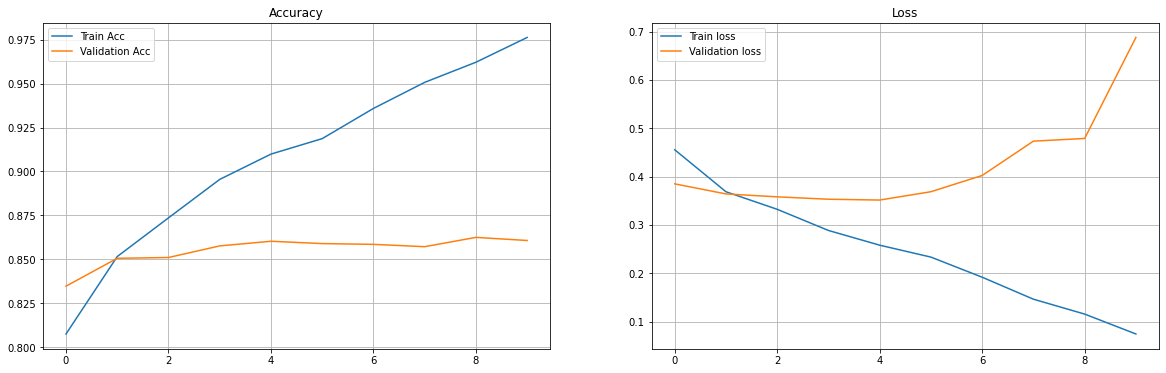

In [149]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [150]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features
def predict_text(text):
        word_seq = np.array([word2idx[preprocess(word)] for word in text.split() 
                         if preprocess(word) in word2idx.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [152]:
index = 121
print(test["Comment"][index])
print('='*70)
print(f'Actual sentiment is  : {train["Rating"][index]}')
print('='*70)
pro = predict_text(train["Comment"][index])
print(pro)
status = "1.0" if pro > 0.5 else "0.0"
pro = (1 - pro) if status == "0.0" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Không gian đẹp, lịch sự, phù hợp để tiếp khách quan trọng. Giá thành tương đối cao, trung bình 1,5tr / người. Riêng đĩa salat rẻ nhất cũng 170k. Chất lượng hải sản ngon nhưng cách chế biến không có gì nổi bật. Phục vụ cũng chỉ được đánh giá trung bình so với tiêu chuẩn của 1 nhà hàng 5 sao
Actual sentiment is  : 1.0
0.9903529286384583
Predicted sentiment is 1.0 with a probability of 0.9903529286384583


In [153]:
test = pd.read_csv("./input/test.csv")
test.insert(2, column = "Rating", value = 0.0) 
for i, item in test.iterrows():
    print(i)
    if isNaN(test['Comment'][i]):
        continue
    pro = predict_text(test['Comment'][i])
    status = 1.0 if pro > 0.5 else 0.0
#     print(test['Comment'][i] , ' -- ', status)
    test['Rating'][i] = status

print(test)
# test.to_csv('result.csv')  

0
1
2


<ipython-input-153-1f8778c70bc9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Rating'][i] = status


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702


In [154]:
import csv
test.to_csv('pre_result.csv')
v = pd.read_csv("./pre_result.csv")
with open("./pre_result.csv", "r") as source:
    reader = csv.reader(source)
      
    with open("result.csv", "w") as result:
        writer = csv.writer(result)
        for r in reader:
            
            # Use CSV Index to remove a column from CSV
            #r[3] = r['RevId']
            writer.writerow((r[2], r[3]))

,Unnamed: 0,Unnamed: 0.1,RevId,Rating,UserId,Comment,image_urls
0,0,0,781115,0.0,1326532,Trà táo 35k\nCookie socola 38k \nNước ở đây bì...,['https://images.foody.vn/res/g8/73091/s800/fo...
1,1,1,1219481,0.0,422306,Hôm rồi trung tâm mình tổ chức noel party ở đâ...,['https://images.foody.vn/res/g1/33/s800/foody...
2,2,2,1703765,1.0,9779143,Thịt gà của quán là nhất đấy. Đi ăn gọi liền 4...,['https://images.foody.vn/res/g66/659655/s800/...
3,3,3,4870346,0.0,12924388,Hai đứa ăn xong đau bụng cả ngày\nChân gà ok n...,['https://images.foody.vn/res/g78/772244/s800/...
4,4,4,2638711,1.0,1134279,Mình vừa thử trưa nay. Điểm cộng đầu tiên là b...,['https://images.foody.vn/res/g74/737874/s800/...
